In [1]:
import json
import pandas as pd
import re

# Données

In [2]:
# Open your JSON file and load it as a list of dictionaries
with open('data/subset_epita.json') as f:
    data_list = json.load(f)

# Convert each dictionary to a JSON string and store in a new list
json_strings = [json.dumps(item) for item in data_list]

# Convert this list to a DataFrame
df = pd.DataFrame(json_strings, columns=['json_string'])

# Print the first few rows to check
df.head()

,json_string
0,"{""0"": [{""line"": {""words"": [{""text"": ""cerfa"", ""..."
1,"{""0"": [{""line"": {""words"": [{""text"": ""Madame"", ..."
2,"{""0"": [{""line"": {""words"": [{""text"": ""CARTE"", ""..."
3,"{""0"": [{""line"": {""words"": [{""text"": ""SECURITY""..."
4,"{""0"": [{""line"": {""words"": [{""text"": ""Docteur"",..."


In [3]:
def has_document_type_id(input_dict, document_type_id):
    if isinstance(input_dict, dict):
        for key, value in input_dict.items():
            if key == "document_type_id" and value == document_type_id:
                return True
            if isinstance(value, dict):
                if has_document_type_id(value, document_type_id):
                    return True
            elif isinstance(value, list):
                for item in value:
                    if isinstance(item, dict):
                        if has_document_type_id(item, document_type_id):
                            return True
    return False

df = df[df['json_string'].apply(lambda x: has_document_type_id(json.loads(x), 8))]

In [4]:
df

,json_string
5,"{""0"": [{""line"": {""words"": [{""text"": ""From"", ""w..."
75,"{""0"": [{""line"": {""words"": [{""text"": ""PARTIE"", ..."
99,"{""0"": [{""line"": {""words"": [{""text"": ""LABORATOI..."
117,"{""0"": [{""line"": {""words"": [{""text"": ""LE"", ""wid..."
119,"{""0"": [{""line"": {""words"": [{""text"": ""Mme"", ""wi..."
...,...
2477,"{""0"": [{""line"": {""words"": [{""text"": ""From"", ""w..."
2500,"{""0"": [{""line"": {""words"": [{""text"": ""22.5.2020..."
2530,"{""0"": [{""line"": {""words"": [{""text"": ""Laboratoi..."
2545,"{""0"": [{""line"": {""words"": [{""text"": ""Laboratoi..."


# Code

In [5]:
units = ['ag/ac', 'mui/i', 'mmoles/l', 'nmol/l', 'total/hdl', 'fl', 't/l', 'ui/i', 'meg/l', 'meq/l', 'téra/l', 'ufc/ml', 'uui/ml', 'umol/l', 'mg/mmol', 'ifu/ml', 'cfu/ml', 'g/l', 'a/g', 'ug/l', 'ui/ml', 'g/dl', 'ml', '/s', '/ml', 'pmol/l', 'e/s', 'u/i', 'nmoles/l', 'u/l', 'hdl/ldl', 'umol/l', 'immoles/l', 'ui/', 'ifu/ml', 'ng/l', 'mg/l', 'cfu/ml', 'mui/ml', 't/chol', 'ct/ng', 'mui/ml', 'mg/l', '/w', 'g/l', 'mmol/mol', '/cmia', 'ul/ml', 'mmol/l', 'mmol/l', 'giga/', 'g/l', 'uréase/', 'u/l', 'mul/ml', 'ug/l', 's/co', 'ui/l', 'pui/ml', 'pg/l', 'uui/ml', '/l', 'tera/l', 'mui/l', 'aebel/', 'pg/ml', 'fr/access', 'mui/l', 'ml/min', 'ui/ml', 'ml/min/an', 'ul/ml', 'ufc/ml', 'meq/l', 'u/ml', 'ml/min', 'umol/i', 'g/dl', 'ng/ml', 'lt/sh', 'ng/ml', 'gpo/pap', 'nmol/l', 'ui/ml', 't/l', 'pg/ml', 'mu/', 'giga/l', 'g/l', 'pmol/l', 'ml/mn', "%", 'g/w', 'e/vs', 'a/l', 'mu/i', 'pg']

In [6]:
def verify_digit(word):
    return word.replace(".", "", 1).isdigit() or word.replace(" ", "", 1).isdigit() or word.replace(",", "", 1).isdigit()

In [7]:
def find_unit_value(entity_name, entities_dict, index, data):
    value = None
    unit = None

    # Recherche de la première valeur numérique et la première unité après le marqueur
    for next_index in range(index, len(data)):
        next_item = data[next_index]
        next_line = next_item["line"]
        next_words = [word["text"].replace(":", "", 1) for word in next_line["words"]]
        next_text = " ".join(next_words)

        # Recherche de la valeur dans la ligne
        if value is None:
            for i in range(len(next_words)):
                if verify_digit(next_words[i]):
                    value = next_words[i]
                    if i > 0 and (next_words[i - 1] == '<' or next_words[i - 1] == '>'):
                        value = next_words[i-1] + ' ' + value
                    break

        # Recherche de l'unité dans la ligne
        if unit is None:
            for i in range(len(next_words)):
                # Faire un truc pour les unités par rapport au entity_name
                if next_words[i].lower() in units:
                    unit = next_words[i]
                    break

        # Si la valeur et l'unité ont été trouvées, sortie de la boucle
        if value and unit:
            break

    # Si la valeur et l'unité ont été trouvées, stockage des informations dans le dictionnaire des entités
    if value and unit:
        if entity_name in entities_dict :
            entities_dict[entity_name + str(len(entities_dict.keys()))] = {"value": value, "unit": unit}
        else:
            entities_dict[entity_name] = {"value": value, "unit": unit}

def find_through_lines(val, entities_dict):
    for index, item in enumerate(val) :
        line = item["line"]
        words = [re.sub(r"^\W+|\W+$", "", word["text"].lower().replace("*", "", 1)) for word in line["words"]]
        text = " ".join(words)

        if "v.g.m" in words:
            find_unit_value("v.g.m", entities_dict, index, val)

        elif "hémoglobine" in words:
            find_unit_value("hémoglobine", entities_dict, index, val)

        elif "t.c.m.h." in words or "t.c.m.h" in words:
            find_unit_value("t.c.m.h", entities_dict, index, val)

        elif "c.c.m.h." in words or "c.c.m.h" in words:
            find_unit_value("c.c.m.h", entities_dict, index, val)
                
        elif "leucocytes" in words:
            find_unit_value("leucocytes", entities_dict, index, val)
        
        elif "hématies" in words or "hematies" in words:
            find_unit_value("hématies", entities_dict, index, val)
        
        elif "creatinine" in words:
            find_unit_value("creatinine", entities_dict, index, val)
        
        elif "transaminases" in words:
            find_unit_value("transaminases", entities_dict, index, val)
        
        elif "enzymologie" in words:
            find_unit_value("enzymologie", entities_dict, index, val)
        
        elif "ckd-epi" in words:
            find_unit_value("ckd-epi", entities_dict, index, val)
        
        elif "hématocrite" in words:
            find_unit_value("hématocrite", entities_dict, index, val)
        
        elif "idr" in words:
            find_unit_value("idr", entities_dict, index, val)
        
        elif "b12" in words:
            find_unit_value("b12", entities_dict, index, val)
        
        elif "enzymatique" in words:
            find_unit_value("enzymatique", entities_dict, index, val)
            
        elif all(elem in words for elem in ['volume', 'globulaire', 'moyen']):
            find_unit_value("globulaire", entities_dict, index, val)
            
        elif "neutrophiles" in words:
            find_unit_value("neutrophiles", entities_dict, index, val)
        
        elif "eosinophiles" in words:
            find_unit_value("eosinophiles", entities_dict, index, val)
        
        elif "basophiles" in words:
            find_unit_value("basophiles", entities_dict, index, val)
        
        elif "lymphocytes" in words:
            find_unit_value("lymphocytes", entities_dict, index, val)
        
        elif "monocytes" in words :
            find_unit_value("monocytes", entities_dict, index, val)
        
        elif "plaquettes" in words:
            find_unit_value("plaquettes X", entities_dict, index, val)
            
def iterate_over_all_docs(dataframe, entities_dict):
    for doc in dataframe['json_string'] :
        doc_dict = json.loads(doc)
        for val in doc_dict.values():
            if type(val) is not list :
                continue
            find_through_lines(val, entities_dict)
    # Affichage des informations extraites
    for entity, info in entities.items():
        print(f"{entity}:")
        print(f"Valeur: {info['value']}")
        print(f"Unité: {info['unit']}")
        print()
            
def search_doc(doc, entities_dict):
    for val in doc.values():
        if type(val) is not list:
            continue
        find_through_lines(val, entities_dict)
    return entities_dict

# Test

#### Texte 5

In [8]:
search_doc(json.loads(df['json_string'][5]), {})

{'leucocytes': {'value': '5 000', 'unit': '/mL'},
 'hématies': {'value': '< 1000', 'unit': '/mL'}}

#### Texte 117

Quand on remet en format PDF, on voit bien que 8,0 est sur la même ligne que le mot ``Enzymatique`` mais lorsqu'on affiche les mots de cette ligne, il n'apparait pas.
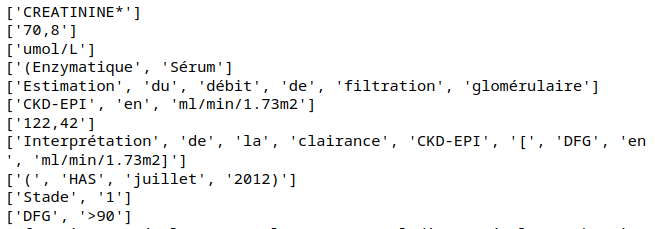

In [9]:
search_doc(json.loads(df['json_string'][117]), {})

{'creatinine': {'value': '70,8', 'unit': 'umol/L'},
 'enzymatique': {'value': '122,42', 'unit': 'U/I'},
 'ckd-epi': {'value': '122,42', 'unit': 'U/I'},
 'ckd-epi3': {'value': '1', 'unit': 'U/I'},
 'ckd-epi4': {'value': '75', 'unit': 'U/I'},
 'enzymologie': {'value': '28', 'unit': 'U/I'},
 'transaminases': {'value': '28', 'unit': 'U/I'}}

L'algorithme peut poser des problèmes sur des mots qui ne sont pas des marqueurs donc il faut faire attention à ce qu'on cherche.
Par exemple ``Enzymologie`` n'est pas un marqueur mais notre fonction cherche la valeur numérique et l'unité la plus proche du mot cherché.

#### Texte 160

In [10]:
search_doc(json.loads(df['json_string'][160]), {})

{'leucocytes': {'value': '5,1', 'unit': 'G/L'},
 'hématies': {'value': '3,99', 'unit': 'Téra/l'},
 'hémoglobine': {'value': '12,5', 'unit': 'g/dL'},
 'hématocrite': {'value': '37,2', 'unit': '%'},
 'globulaire': {'value': '93', 'unit': 'fL'},
 't.c.m.h': {'value': '31,3', 'unit': 'pg'},
 'c.c.m.h': {'value': '33,5', 'unit': 'g/dL'},
 'idr': {'value': '13,0', 'unit': '%'},
 'neutrophiles': {'value': '57,6', 'unit': '%'},
 'eosinophiles': {'value': '1,4', 'unit': '%'},
 'basophiles': {'value': '0,6', 'unit': '%'},
 'lymphocytes': {'value': '30,6', 'unit': '%'},
 'monocytes': {'value': '9,8', 'unit': '%'},
 'plaquettes X': {'value': '222', 'unit': 'G/L'},
 'b12': {'value': '339', 'unit': 'pg/ml'}}

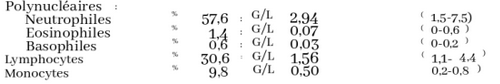
Pour l'instant on récupère la première valeur donc ici le pourcentage.

## Contraintes

Pour que notre code fonctionne correctement avec tous les types de document, il faut renseigner toutes les unités possibles. C'est l'un des plus gros désavantages. Il faut faire de même pour les marqueurs qu'on cherche mais le nom des marqueurs peuvent varier selon les documents. Par exemple ``T.C.M.H`` et ``T.C.M.H.`` ou encore parfois il y a un symbole dans le mot qui fait qu'on ne le reconnait plus : ``CREATININE*`` ou ``pg/ml:``.

Pour améliorer la recherche, on aurait besoin de la liste des unités pour chaque marqueurs pour éviter de chercher une unité qui ne correspond pas à un marqueur.